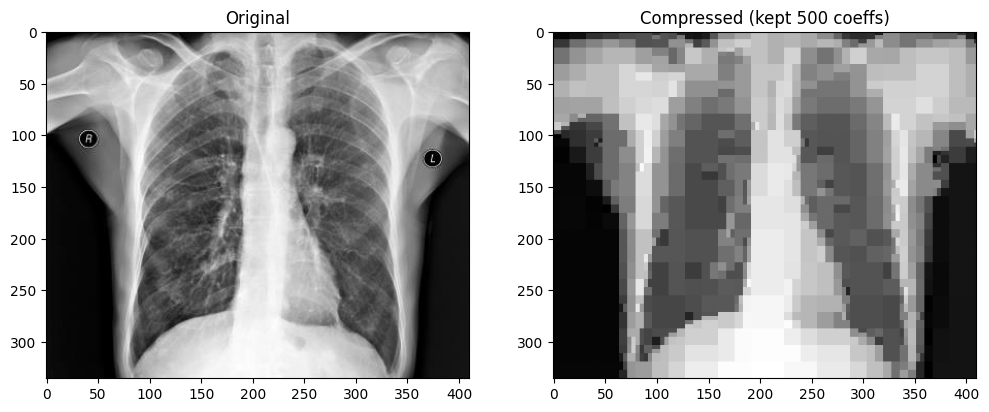

In [62]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pywt

def haar_compress(image_path, num_keep=1000):
    try:
        img = Image.open(image_path).convert('L')
        img_array = np.array(img, dtype=np.float32)

        coeffs = pywt.wavedec2(img_array, 'haar', level=None)
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

        
        flat = coeff_arr.flatten()
        sorted_indices = np.argsort(-np.abs(flat))
        threshold_indices = sorted_indices[num_keep:]
        flat[threshold_indices] = 0
        compressed_arr = flat.reshape(coeff_arr.shape)

        
        compressed_coeffs = pywt.array_to_coeffs(compressed_arr, coeff_slices, output_format='wavedec2')
        reconstructed = pywt.waverec2(compressed_coeffs, 'haar')

        
        reconstructed = np.clip(reconstructed, 0, 255).astype(np.uint8)

        
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img_array, cmap='gray')
        plt.title("Original")

        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed, cmap='gray')
        plt.title(f"Compressed (kept {num_keep} coeffs)")
        plt.show()

        return reconstructed

    except Exception as e:
        print(f"Ошибка: {str(e)}")
        return None


compressed = haar_compress("rentgen_grudnoy_kletki.jpg", num_keep=500)


In [39]:
from skimage.metrics import structural_similarity as ssim
import cv2

def compare_images(img1_path, img2_path):
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    if img1 is None or img2 is None:
        raise ValueError("Одно или оба изображения не удалось загрузить.")

    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    score, diff = ssim(img1, img2, full=True)
    return score


In [40]:
import math
import numpy as np
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

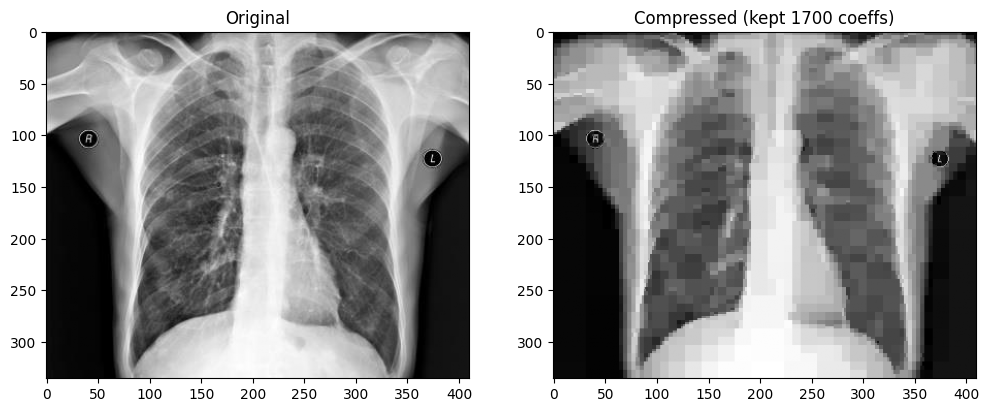

PSNR: 27.36 dB


In [70]:
original_img = Image.open("rentgen_grudnoy_kletki.jpg").convert('L')
original_array = np.array(original_img, dtype=np.float32)


compressed_array = haar_compress("rentgen_grudnoy_kletki.jpg", num_keep=1700)


psnr_value = PSNR(original_array, compressed_array)
print(f"PSNR: {psnr_value:.2f} dB")

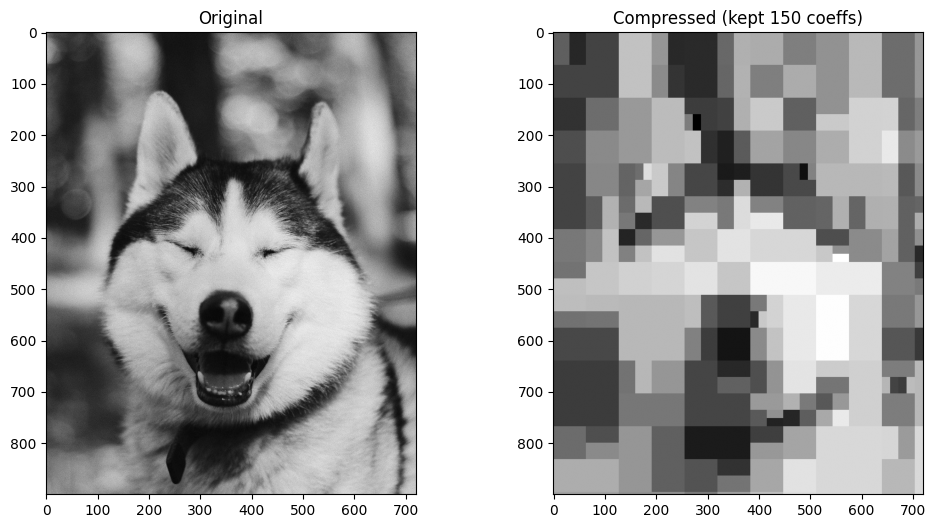

SSIM: 0.4758


In [42]:
from PIL import Image
import numpy as np

original_img = Image.open("happy-dog.jpg").convert('L')
original_array = np.array(original_img, dtype=np.uint8)

compressed_array = haar_compress("happy-dog.jpg", num_keep=150)
compressed_array = compressed_array.astype(np.uint8)

def compare_arrays(img1_array, img2_array):
    if img1_array.shape != img2_array.shape:
        raise ValueError("IMage size.")
    score, _ = ssim(img1_array, img2_array, full=True)
    return score

ssim_value = compare_arrays(original_array, compressed_array)
print(f"SSIM: {ssim_value:.4f}")


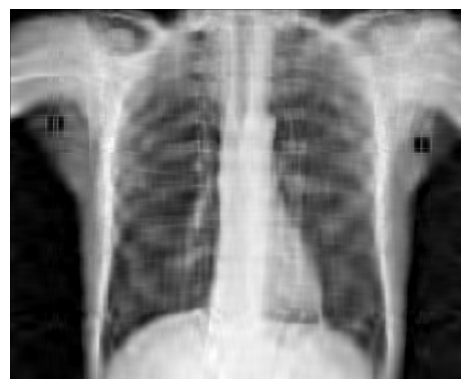

In [67]:

import cv2 as cv
import numpy as np

from collections import namedtuple
def mySVD(A):

    SVD_res = namedtuple('SVD_res', ['U', 'S', 'Vt'])

    A_transpose = A.T

    comp_V = np.dot(A_transpose, A)

    eigvalues_V, V = np.linalg.eig(comp_V)

    ind = np.argsort(eigvalues_V)[::-1]
    singular_values = np.sqrt(eigvalues_V[ind])

    U= V[:, np.argsort(eigvalues_V)[::-1]]
    U = np.dot(A, V)
    U = U / np.linalg.norm(U, axis=0)
    U = U[:, np.argsort(eigvalues_V)[::-1]]
    return SVD_res(U, singular_values, V.T)
def reduced_svd(A: np.ndarray):
    """
    Perform reduced Singular Value Decomposition (SVD) on a matrix A.
    Returns U, singular_values, and V matrices such that A = U * S * V^T.
    """
    ATA = np.dot(A.T, A)

    def sorted_matrix(A):
        eigen_val, eigen_vectors = np.linalg.eigh(A)

        sorted_pairs = sorted([(eigen_val[i], eigen_vectors[:, i]) for i in range(len(eigen_val))], key=lambda x: x[0])[::-1]

        sorted_evectors = [ele[1] for ele in sorted_pairs]
        sorted_eval = [ele[0] for ele in sorted_pairs]
        return np.array(sorted_evectors).T, np.array(sorted_eval)

    V, sorted_eigenvalues = sorted_matrix(ATA)
    singular_values = np.sqrt(np.abs(sorted_eigenvalues))

    tol = 1e-10 * np.max(singular_values) if len(singular_values) > 0 else 1e-10
    rank = np.sum(singular_values > tol)

    singular_values = singular_values[:rank]
    V = V[:, :rank]

    U = np.zeros((A.shape[0], rank))
    for i in range(rank):
        if singular_values[i] > tol:
            U[:, i] = np.dot(A, V[:, i]) / singular_values[i]

    return U, singular_values, V.T

image_path = 'rentgen_grudnoy_kletki.jpg'
image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
image = image.astype('float32')

U, singular_values, V = reduced_svd(image)


k = 18
singular_values_k = singular_values[:k]
U_k = U[:, :k]
V_k = V[:k, :]


compressed_image = np.dot(U_k, np.dot(np.diag(singular_values_k), V_k))


compressed_image = np.clip(compressed_image, 0, 255).astype('uint8')


plt.imshow(compressed_image, cmap='gray')  
plt.axis('off')  
plt.show()

In [68]:
psnr_value = PSNR(image, compressed_image)
print(f"PSNR для k = {k}: {psnr_value:.2f} dB")

PSNR для k = 18: 28.49 dB


In [45]:
from PIL import Image
import numpy as np

original_img = Image.open("happy-dog.jpg").convert('L')


ssim_value = compare_arrays(original_array, compressed_image)
print(f"SSIM: {ssim_value:.4f}")

SSIM: 0.5937
